## E-Scooter Trips 2018-2019 Lousiville

In [24]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pyproj import Geod


In [25]:
sns.set_style("whitegrid")

### 1. Loading dataset

In [26]:
df = pd.read_csv("data/DocklessTripOpenData_9.csv")
df.head()

,TripID,StartDate,StartTime,EndDate,EndTime,TripDuration,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
0,0000045c-2677-3a7d-4b73-cad99a57,2019-06-26,19:30,2019-06-26,19:30,3.0,0.000,38.253,-85.756,38.253,-85.755,4,19
1,0000487b-92e6-50d6-7569-42ed3818,2019-09-22,14:30,2019-09-22,14:30,5.0,0.000,38.207,-85.747,38.206,-85.748,1,14
2,00006088-2579-e0d0-6a30-a15bb878,2019-08-21,17:30,2019-08-21,17:30,6.0,0.330,38.264,-85.728,38.261,-85.730,4,17
3,00008c1a-899b-8596-970f-9f6bf495,2019-07-03,11:00,2019-07-03,11:15,6.0,0.640,38.217,-85.757,38.221,-85.763,4,11
4,000096c8-bac3-4d6f-7ebb-30b957ee,2019-05-04,21:15,2019-05-04,21:30,7.0,0.684,38.221,-85.762,38.223,-85.764,7,21


### 2. Data information

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434582 entries, 0 to 434581
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TripID          434582 non-null  object 
 1   StartDate       434582 non-null  object 
 2   StartTime       434582 non-null  object 
 3   EndDate         434578 non-null  object 
 4   EndTime         434578 non-null  object 
 5   TripDuration    434582 non-null  float64
 6   TripDistance    434582 non-null  float64
 7   StartLatitude   434582 non-null  float64
 8   StartLongitude  434582 non-null  float64
 9   EndLatitude     434582 non-null  float64
 10  EndLongitude    434582 non-null  float64
 11  DayOfWeek       434582 non-null  int64  
 12  HourNum         434582 non-null  int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 43.1+ MB


### 3. Data preprocessing
We create following rules for the data:
1. Trip needs to last at least 1.5 minutes
2. Length of a trip needs to be at least 150 meters

In [28]:
original_shape = df.shape

#### Dropping rows where distance is less than 150 meters or time is less than 90 seconds

In [29]:
df = df.drop(df[(df['TripDistance'] < 0.15) | (df['TripDuration'] < 1.5)].index)
new_shape = df.shape

In [30]:
print(f"Number of rows dropped: {original_shape[0] - new_shape[0]}")

Number of rows dropped: 113622


### 4. Number of trips by date, day of week and hour

In [31]:
df['StartDate'] = pd.to_datetime(df['StartDate'])

In [32]:
ntd = df.groupby("StartDate")["StartDate"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

,Date,Trips
0,2018-08-09,265
1,2018-08-10,433
2,2018-08-11,242
3,2018-08-12,301
4,2018-08-13,157


In [33]:
ntd.tail()

,Date,Trips
443,2019-10-27,497
444,2019-10-28,521
445,2019-10-29,505
446,2019-10-30,208
447,2019-10-31,202


#### Average trips per day

In [34]:
atpd = round(ntd["Trips"].mean())
print(f"Average trips per day: {atpd} trips")

Average trips per day: 716 trips


#### 4.1. Number of trips per date

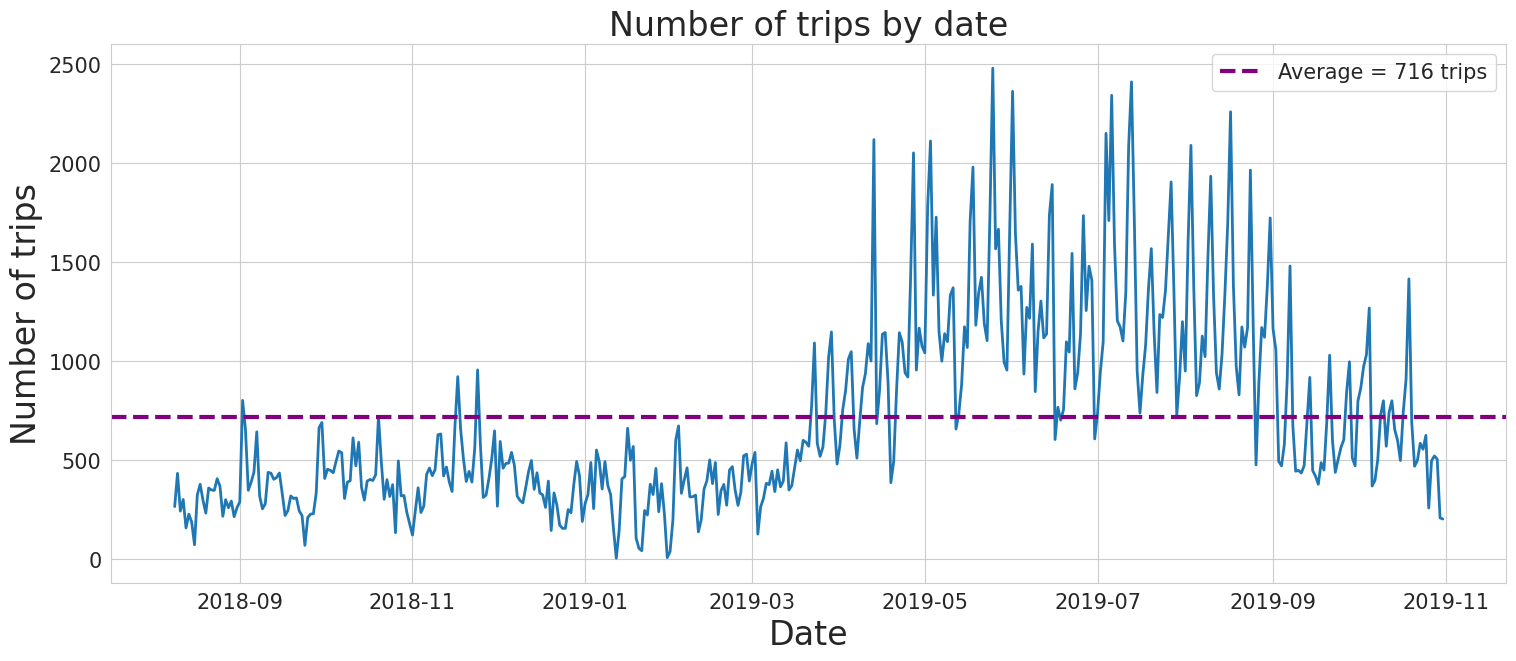

In [35]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trips", data=ntd, linewidth=2)
plot.axhline(atpd, linestyle="--", color="purple", label=f"Average = {atpd} trips", linewidth=3)
plt.title("Number of trips by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.2. Number of trips by day of week

#### Extracting day of week from Start Date column

In [36]:
df["Day of Week"] = df["StartDate"].dt.day_name()

In [37]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("Day of Week")["Day of Week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day of Week", "Trips"]
tdw

,Day of Week,Trips
0,Monday,36597
1,Tuesday,39179
2,Wednesday,41429
3,Thursday,44498
4,Friday,53016
5,Saturday,63570
6,Sunday,42671


#### Average trips per day of week

In [38]:
atdw = round(tdw["Trips"].mean())
print(f"Average trips per day of week: {atdw}")

Average trips per day of week: 45851


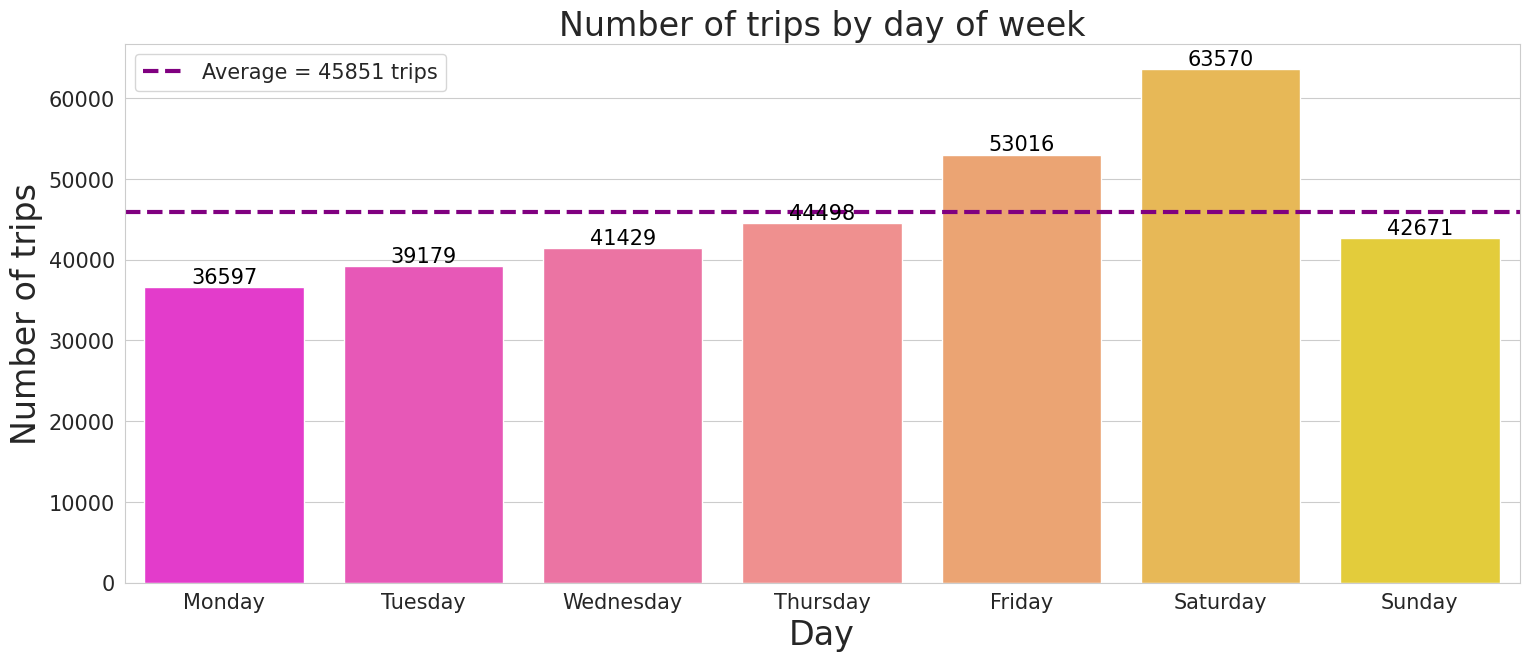

In [39]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Trips", data=tdw, palette="spring")
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=15)
plot.axhline(atdw, linestyle="--", color="purple", label=f"Average = {atdw} trips", linewidth=3)
plt.title("Number of trips by day of week", size=24)
plt.xlabel("Day", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.3. Distribution of trips over hours of the day

In [40]:
df["StartTime"] = np.where(df['StartTime']=='24:00', '00:00', df["StartTime"])
df["Hour"] = pd.to_datetime(df["StartTime"]).dt.hour

In [41]:
thd = df["Hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

,Hour,Trips
0,16,25552
1,15,25448
2,14,24611
3,13,24180
4,17,23760
5,12,23224
6,18,20374
7,11,20280
8,19,18930
9,20,17670


#### Average trips per hour

In [42]:
athd = round(thd["Trips"].mean())
print(f"Average trips per hour: {athd}")

Average trips per hour: 13373


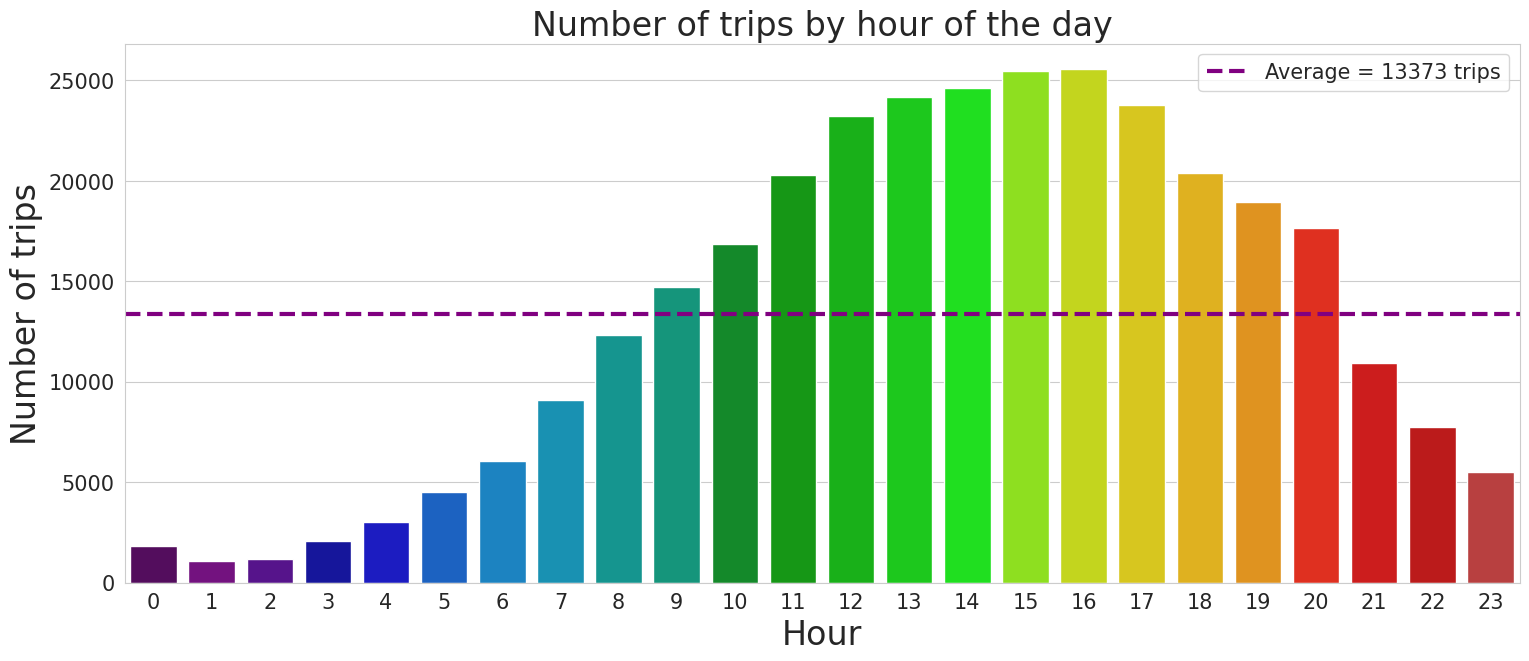

In [43]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Trips", data=thd, palette="nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label=f"Average = {athd} trips", linewidth=3)
plt.title("Number of trips by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.4. Number of trips by start area

#### Adding new columns with information about the neighbourhood that given location is in and coordinates describing the center of this neighbourhood

In [44]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [45]:
for start_lat in df["StartLatitude"].values:
    if start_lat not in area_key:
        area_key[start_lat] = area_idx
        area_idx+=1
for end_lat in df["EndLatitude"].values:
    if end_lat not in area_key:
        area_key[end_lat] = area_idx
        area_idx+=1

NameError: name 'area_key' is not defined

In [46]:
from tqdm import tqdm
road_map = {}
area_coords = {}
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, start_lon, end_lat, end_lon = row.StartLatitude, row.StartLongitude, row.EndLatitude, row.EndLongitude
    if start_lat not in road_map:
        start_loc = geolocator.reverse(f"{start_lat},{start_lon}")
        if start_loc and 'road' in start_loc.raw['address']:
            start_loc = start_loc.raw
            start_neigh = start_loc['address']['road']
            road_map[start_lat] = start_neigh
            area_center = geolocator.geocode(f"Louisville {start_neigh}")
            if area_center:
                area_coords[start_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}
    if end_lat not in road_map:
        end_loc = geolocator.reverse(f"{end_lat},{end_lon}")
        if end_loc and 'road' in end_loc.raw['address']:
            end_loc = end_loc.raw
            end_neigh = end_loc['address']['road']
            road_map[end_lat] = end_neigh
            area_center = geolocator.geocode(f"Louisville {end_neigh}")
            if area_center:
                area_coords[end_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}

28864it [02:56, 163.45it/s]


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Louisville+North+Park+Avenue&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [47]:
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat = row.StartLatitude, row.EndLatitude
    if start_lat in road_map:
        start_neigh = road_map[start_lat]
        df.at[index, "Start Area Name"] = start_neigh
        if start_neigh in area_coords:
            df.at[index, "Start Centroid Latitude"] = area_coords[start_neigh]['lat']
            df.at[index, "Start Centroid Longitude"] = area_coords[start_neigh]['lon']
        
    if end_lat in road_map:
        end_neigh = road_map[end_lat]
        df.at[index, "End Area Name"] = end_neigh
        if end_neigh in area_coords:
            df.at[index, "End Centroid Latitude"] = area_coords[end_neigh]['lat']
            df.at[index, "End Centroid Longitude"] = area_coords[end_neigh]['lon']

320960it [00:14, 22190.16it/s]


In [48]:
ntbsa = df["Start Area Name"].value_counts().to_frame().reset_index()
ntbsa.columns = ["Start Area Name", "Trips"]
ntbsa

,Start Area Name,Trips
0,North Clifton Avenue,26711
1,LouieLink Downtown Skywalk System,26157
2,South 3rd Street,23759
3,East Main Street,22403
4,East Witherspoon Street,17799
...,...,...
116,West 95th Street,1
117,Carribean Way,1
118,Old Creek Lane,1
119,Ponder Way,1


#### 4.5. Number of trips by destination area

In [49]:
ntbea = df["End Area Name"].value_counts().to_frame().reset_index()
ntbea.columns = ["End Area Name", "Trips"]
ntbea

,End Area Name,Trips
0,South 3rd Street,24962
1,LouieLink Downtown Skywalk System,23887
2,North Clifton Avenue,23384
3,East Main Street,21434
4,West Market Street,16046
...,...,...
123,Southeast 9th Avenue,1
124,West 32nd Place,1
125,Chesley Drive,1
126,North Park Avenue,1


### 5. Average trip speed (km/h)

#### Creating new column: Average Speed

In [50]:
df["Average Speed"] = df["TripDistance"] / (df["TripDuration"] / 60)

#### Average speed of trip

In [51]:
avs = round(df['Average Speed'].mean(), 2)
print(f"Average speed of trip: {avs} km/h")

Average speed of trip: 5.95 km/h


#### 5.1 Average speed by date

In [52]:
atsbd = df.groupby(["StartDate"]).agg({"Average Speed": "mean"}).reset_index()
atsbd.columns = ["Date", "Average Speed"]
atsbd["Average Speed"] = round(atsbd["Average Speed"], 2)
atsbd.head()

,Date,Average Speed
0,2018-08-09,6.13
1,2018-08-10,6.36
2,2018-08-11,6.21
3,2018-08-12,6.57
4,2018-08-13,6.58


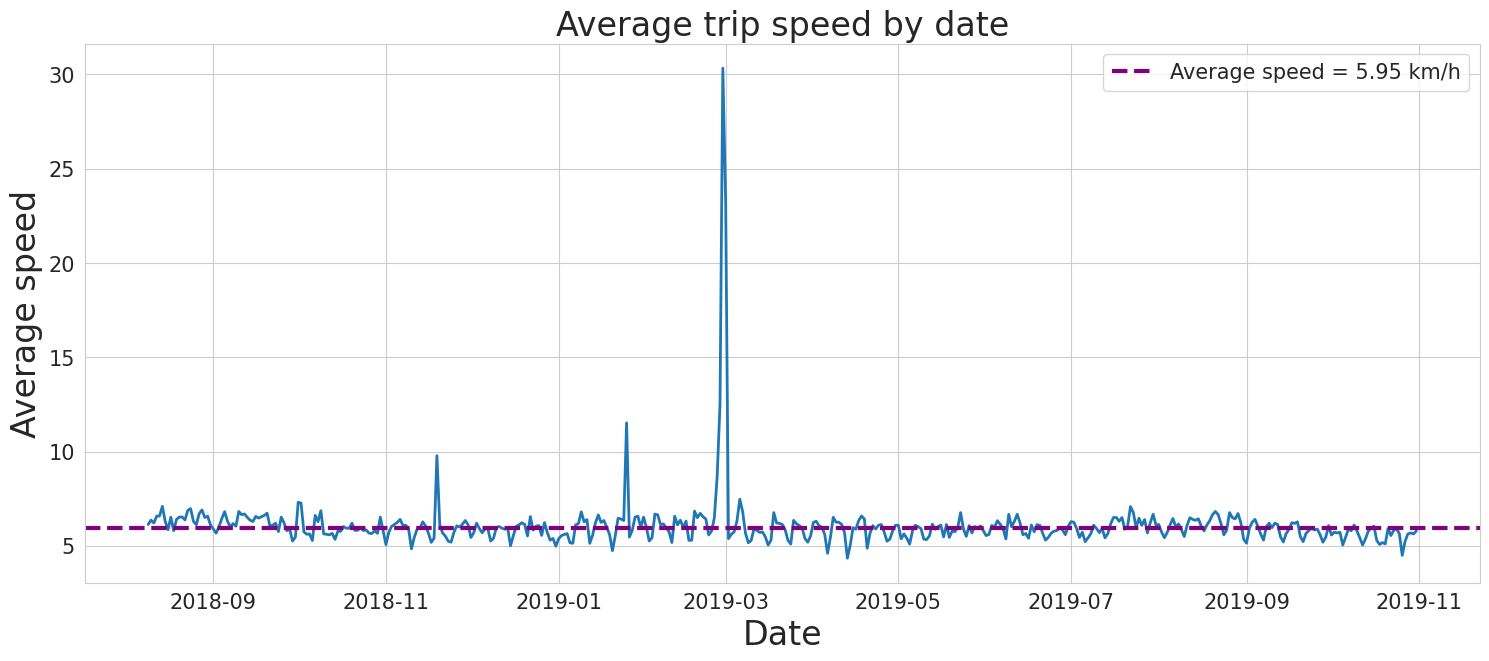

In [53]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Average Speed", data=atsbd, linewidth=2)
plot.axhline(avs, linestyle="--", color="purple", label=f"Average speed = {avs} km/h", linewidth=3)
plt.title("Average trip speed by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average speed", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.2 Average speed by day of week

In [54]:
aspd = df.groupby(["Day of Week"]).agg({"Average Speed": "mean"})
aspd.columns = ["Average Speed"]
aspd["Average Speed"] = round(aspd["Average Speed"], 2)
aspd = aspd.reset_index()
aspd

,Day of Week,Average Speed
0,Friday,6.00
1,Monday,6.15
2,Saturday,5.43
3,Sunday,5.64
4,Thursday,6.28
5,Tuesday,6.21
6,Wednesday,6.22


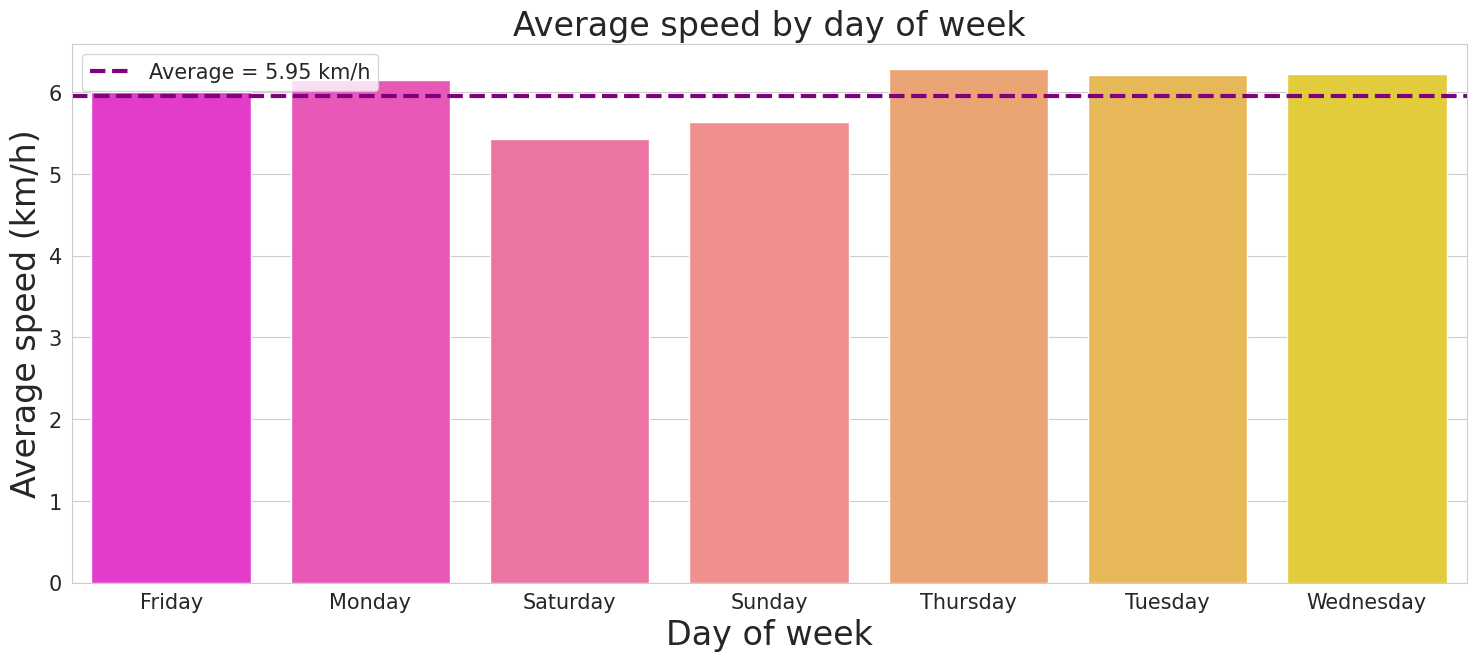

In [55]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Speed", data=aspd, palette="spring")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.3 Average speed by start hour

In [56]:
asph = df.groupby(["Hour"]).agg({"Average Speed": "mean"})
asph.columns = ["Average Speed"]
asph["Average Speed"] = round(asph["Average Speed"], 2)
asph = asph.reset_index()
asph

,Hour,Average Speed
0,0,5.82
1,1,6.56
2,2,7.30
3,3,8.64
4,4,7.69
5,5,7.36
6,6,7.50
7,7,6.38
8,8,6.20
9,9,6.30


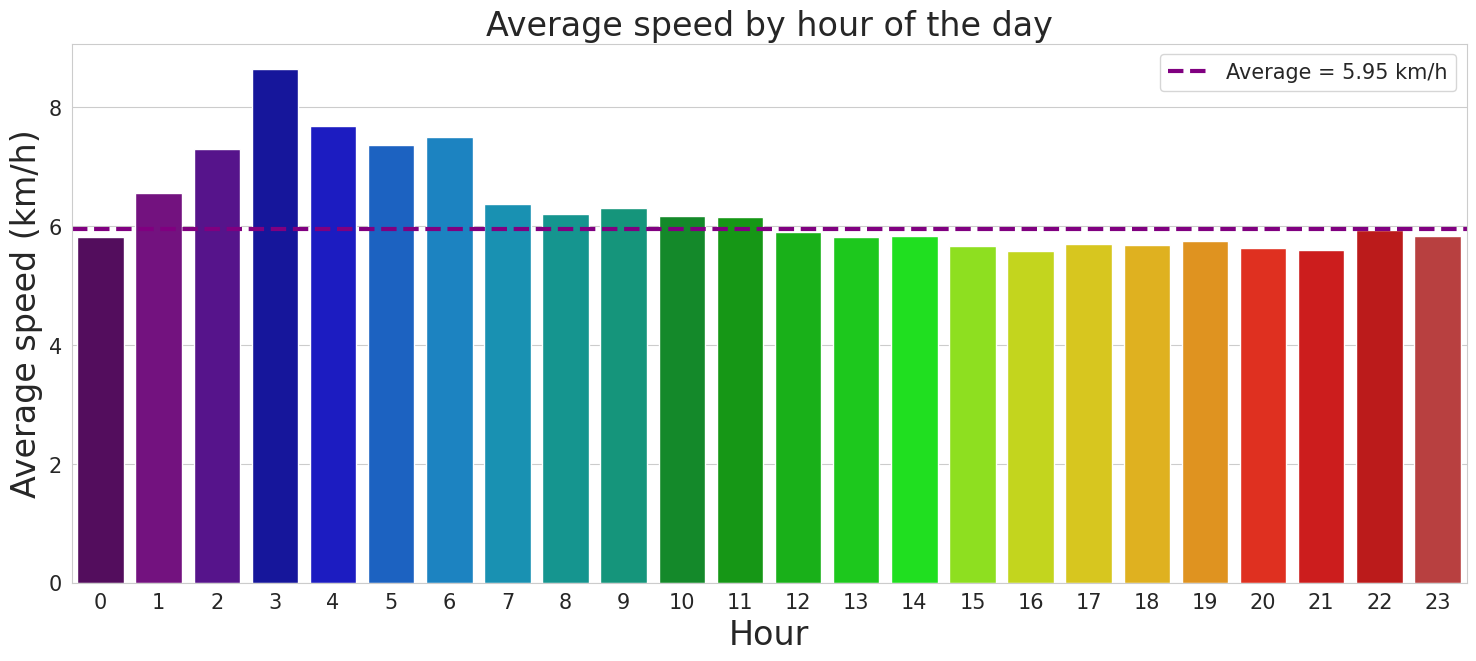

In [57]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Speed", data=asph, palette="nipy_spectral")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 6. Average trip distance

In [58]:
avd = round(df["TripDistance"].mean(), 2)
print(f"Average distance per trip: {avd}km")

Average distance per trip: 1.47km


#### 6.1. Average trip distance by date

In [59]:
atdbd = df.groupby(["StartDate"]).agg({"TripDistance": "mean"}).reset_index()
atdbd.columns = ["Date", "Trip Distance"]
atdbd["Trip Distance"] = round(atdbd["Trip Distance"], 2)
atdbd.head()

,Date,Trip Distance
0,2018-08-09,1.93
1,2018-08-10,1.69
2,2018-08-11,2.54
3,2018-08-12,2.58
4,2018-08-13,2.50


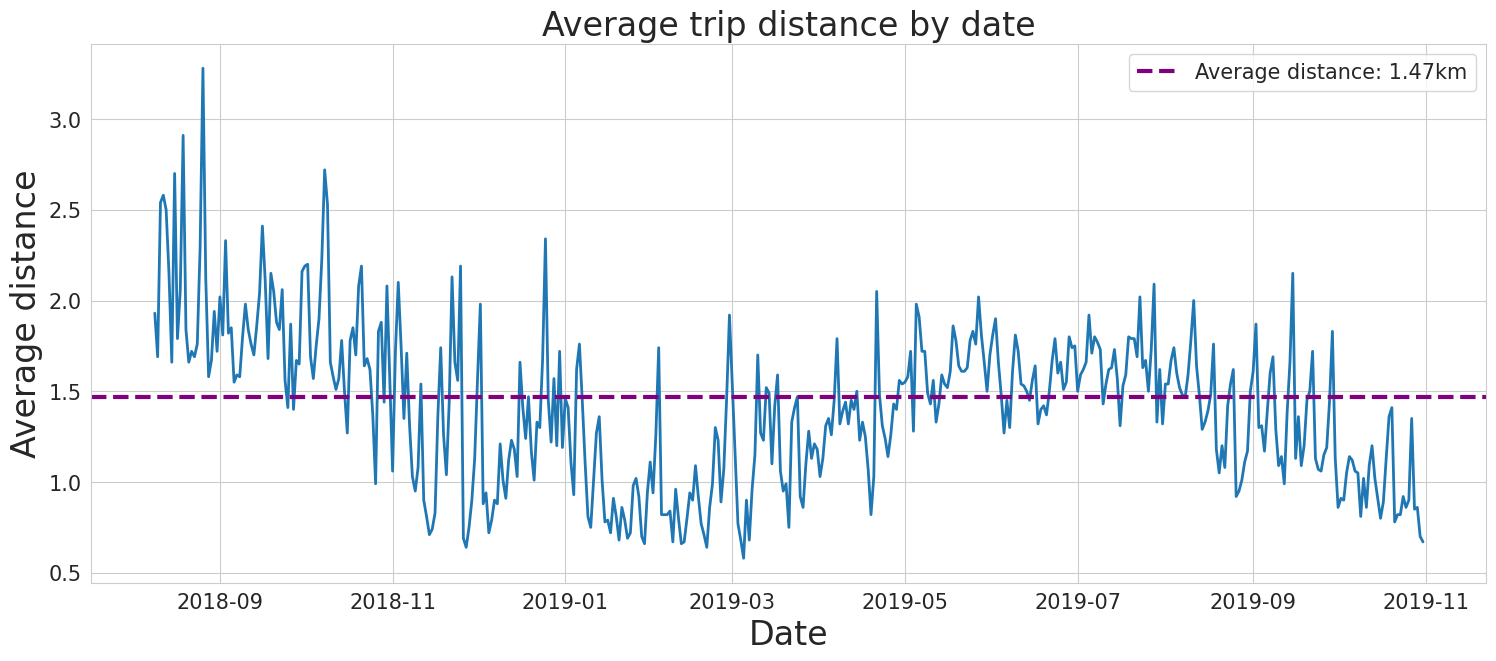

In [60]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trip Distance", data=atdbd, linewidth=2)
plot.axhline(avd, linestyle="--", color="purple", label=f"Average distance: {avd}km", linewidth=3)
plt.title("Average trip distance by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.2. Average trip distance by day of week

In [61]:
adbd = df.groupby(["Day of Week"]).agg({"TripDistance": "mean"})
adbd.columns = ["Average Trip Distance"]
adbd["Average Trip Distance"] = round(adbd["Average Trip Distance"], 2)
adbd = adbd.reset_index()
adbd

,Day of Week,Average Trip Distance
0,Friday,1.43
1,Monday,1.46
2,Saturday,1.57
3,Sunday,1.76
4,Thursday,1.34
5,Tuesday,1.38
6,Wednesday,1.33


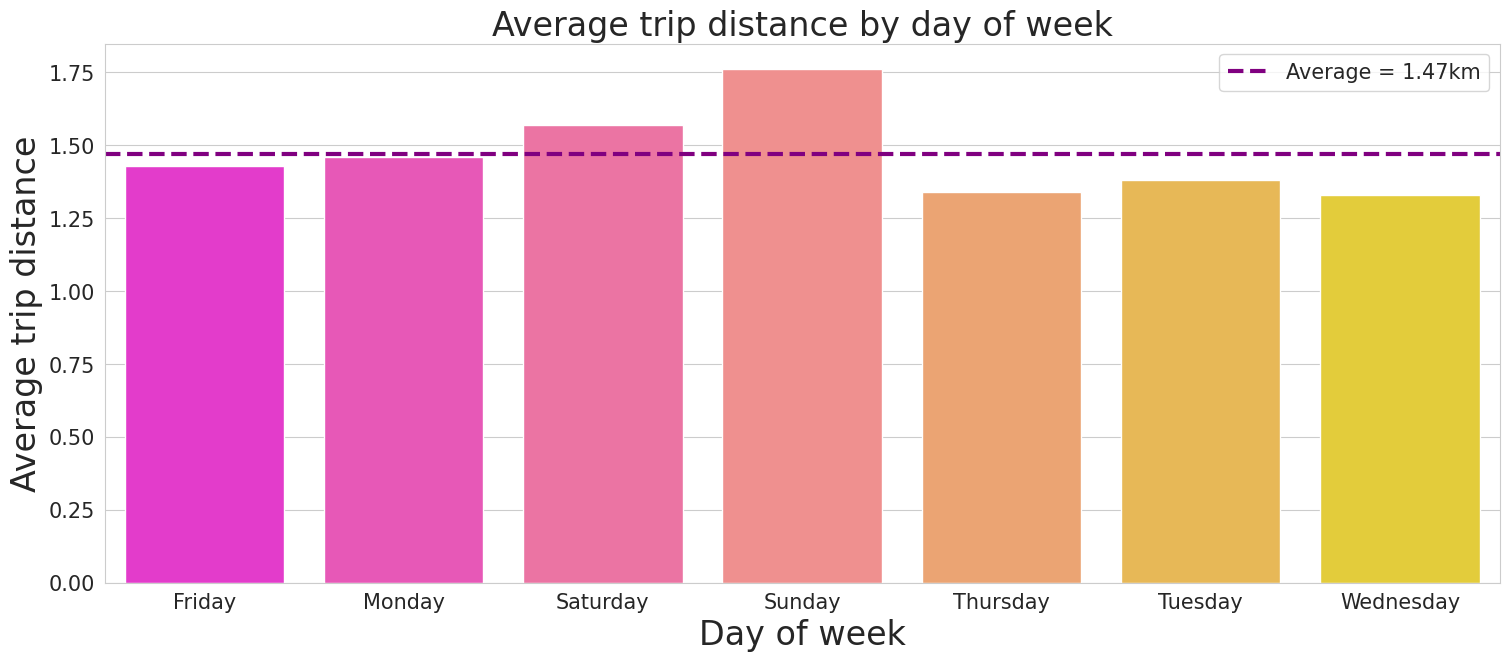

In [62]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Trip Distance", data=adbd, palette="spring")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}km", linewidth=3)
plt.title("Average trip distance by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average trip distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.3. Average trip distance by hour of the day

In [63]:
adbh = df.groupby(["Hour"]).agg({"TripDistance": "mean"})
adbh.columns = ["Average Trip Distance"]
adbh["Average Trip Distance"] = round(adbh["Average Trip Distance"], 2)
adbh = adbh.reset_index()
adbh

,Hour,Average Trip Distance
0,0,1.84
1,1,1.71
2,2,1.68
3,3,1.25
4,4,1.26
5,5,1.09
6,6,1.11
7,7,1.12
8,8,1.14
9,9,1.22


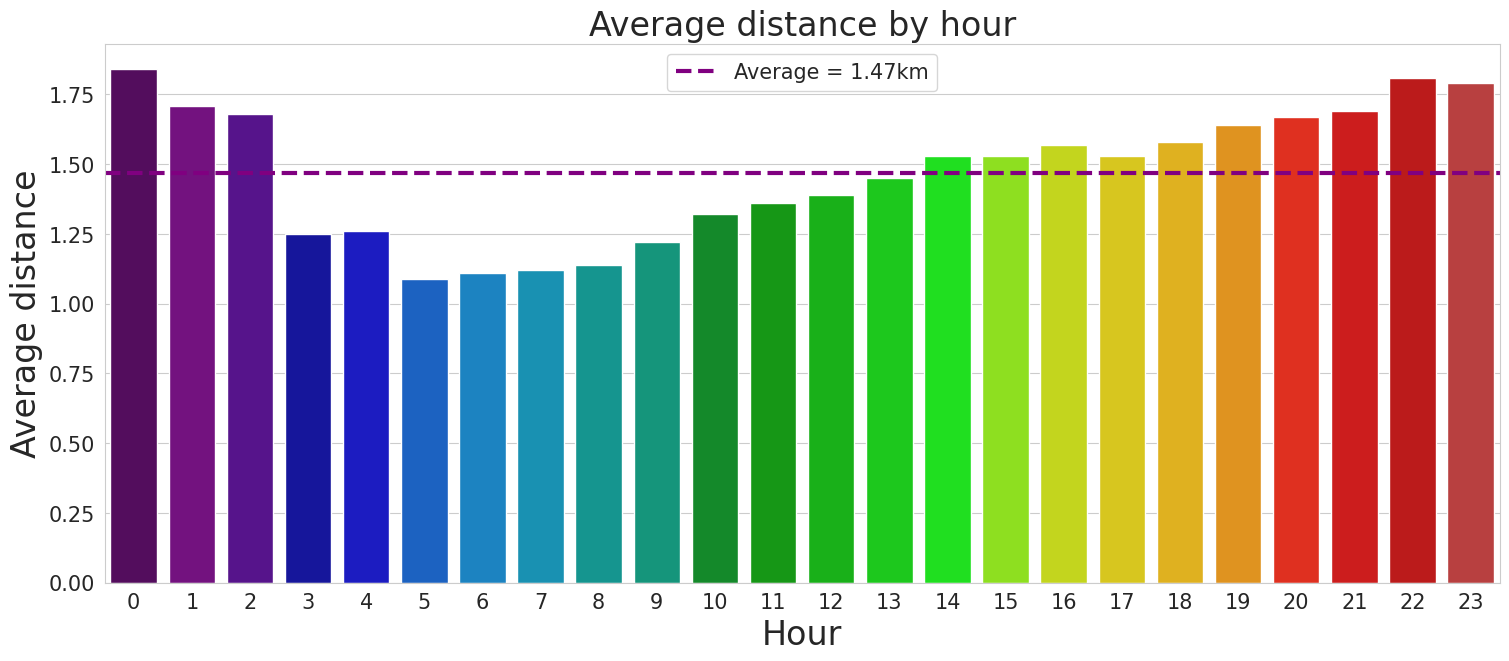

In [64]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Trip Distance", data=adbh, palette="nipy_spectral")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}km", linewidth=3)
plt.title("Average distance by hour", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7. Trips statistics for first and last 15 days

#### First 15 days

In [65]:
ftd = df[(df["StartDate"] >= "2018-08-09") & (df["StartDate"] <= "2018-08-22")]
ftd["Time Period"] = "First 15 Days"

#### Last 15 days

In [66]:
ltd = df[(df["StartDate"] >= "2019-10-18") & (df["StartDate"] <= "2019-10-31")]
ltd["Time Period"] = "Last 15 Days"

In [67]:
fltd = pd.concat([ftd, ltd])

#### 7.1. Statistics by time period

In [68]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                         "TripDistance": "mean",
                                         "TripDuration": "mean",
                                         "Average Speed": "mean"})
fl_15.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fl_15["Trips Distance"] = round(fl_15["Trips Distance"], 2)
fl_15["Trips Duration"] = round(fl_15["Trips Duration"], 2)
fl_15["Average Speed"] = round(fl_15["Average Speed"], 2)
fl_15 = fl_15.reset_index()
fl_15

,Time Period,Trips,Trips Distance,Trips Duration,Average Speed
0,First 15 Days,3824,2.06,21.34,6.38
1,Last 15 Days,7940,1.04,13.71,5.43


#### 7.2. Statistics by day of week and time period

In [69]:
fltdg = fltd.groupby(["Day of Week", "Time Period"]).agg({"Time Period": "count",
                                                          "TripDistance": "mean",
                                                          "TripDuration": "mean",
                                                          "Average Speed": "mean"})
fltdg.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fltdg["Trips Distance"] = round(fltdg["Trips Distance"], 2)
fltdg["Trips Duration"] = round(fltdg["Trips Duration"], 2)
fltdg["Average Speed"] = round(fltdg["Average Speed"], 2)
fltdg = fltdg.reset_index()
fltdg

,Day of Week,Time Period,Trips,Trips Distance,Trips Duration,Average Speed
0,Friday,First 15 Days,758,1.73,17.36,6.43
1,Friday,Last 15 Days,1534,1.02,13.79,5.30
2,Monday,First 15 Days,389,2.11,20.44,6.55
3,Monday,Last 15 Days,990,0.82,10.35,5.77
4,Saturday,First 15 Days,620,2.24,25.69,5.96
5,Saturday,Last 15 Days,1674,1.29,17.89,5.06
6,Sunday,First 15 Days,598,2.75,27.92,6.48
7,Sunday,Last 15 Days,1189,1.39,18.72,5.16
8,Thursday,First 15 Days,337,2.09,21.58,6.07
9,Thursday,Last 15 Days,757,0.85,9.45,5.88


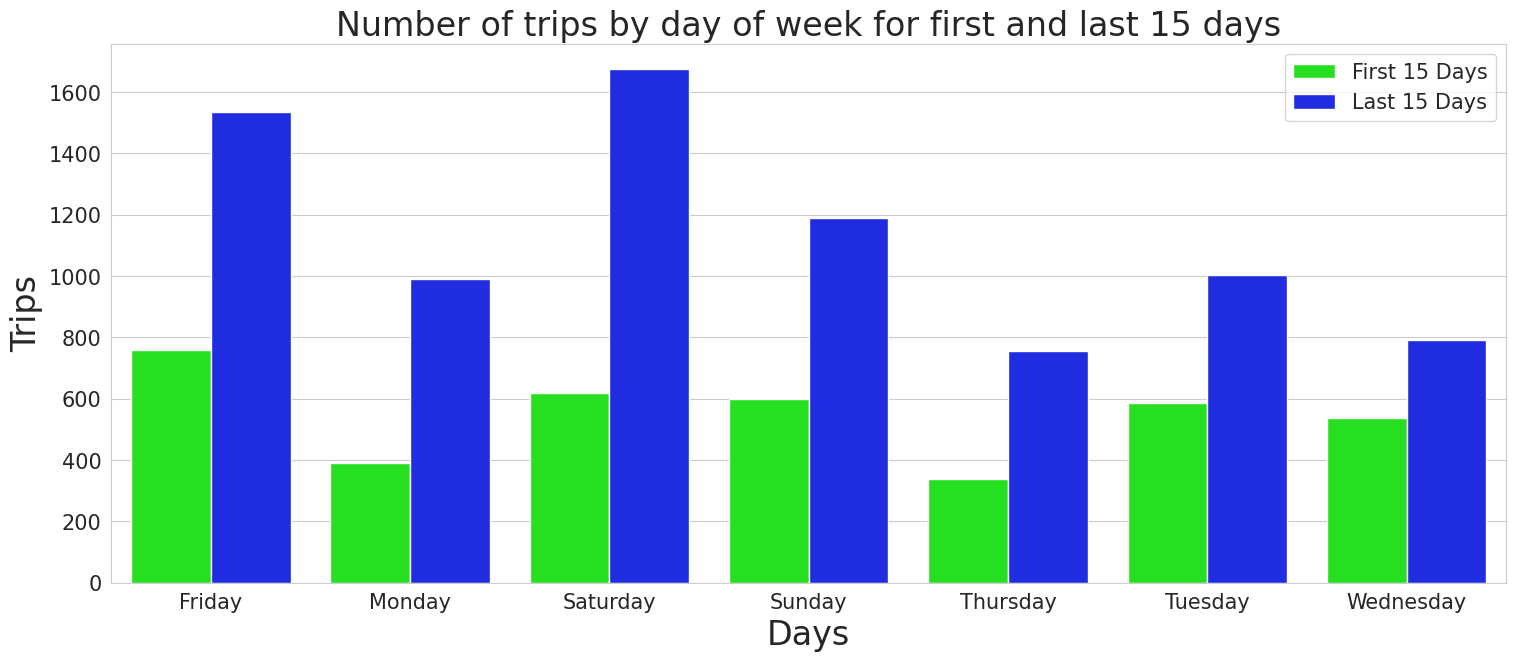

In [70]:
plt.figure(figsize=(18, 7))
sns.barplot(x="Day of Week", y="Trips", hue="Time Period", data=fltdg, palette="hsv")
plt.title("Number of trips by day of week for first and last 15 days", size=24)
plt.xlabel("Days", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 7.3. Statistics by hour and time period

In [71]:
fltdh = fltd.groupby(["Hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

,Hour,Time Period,Trips
0,5,First 15 Days,9
1,6,First 15 Days,11
2,6,Last 15 Days,57
3,7,First 15 Days,33
4,7,Last 15 Days,158
5,8,First 15 Days,67
6,8,Last 15 Days,254
7,9,First 15 Days,90
8,9,Last 15 Days,385
9,10,First 15 Days,116


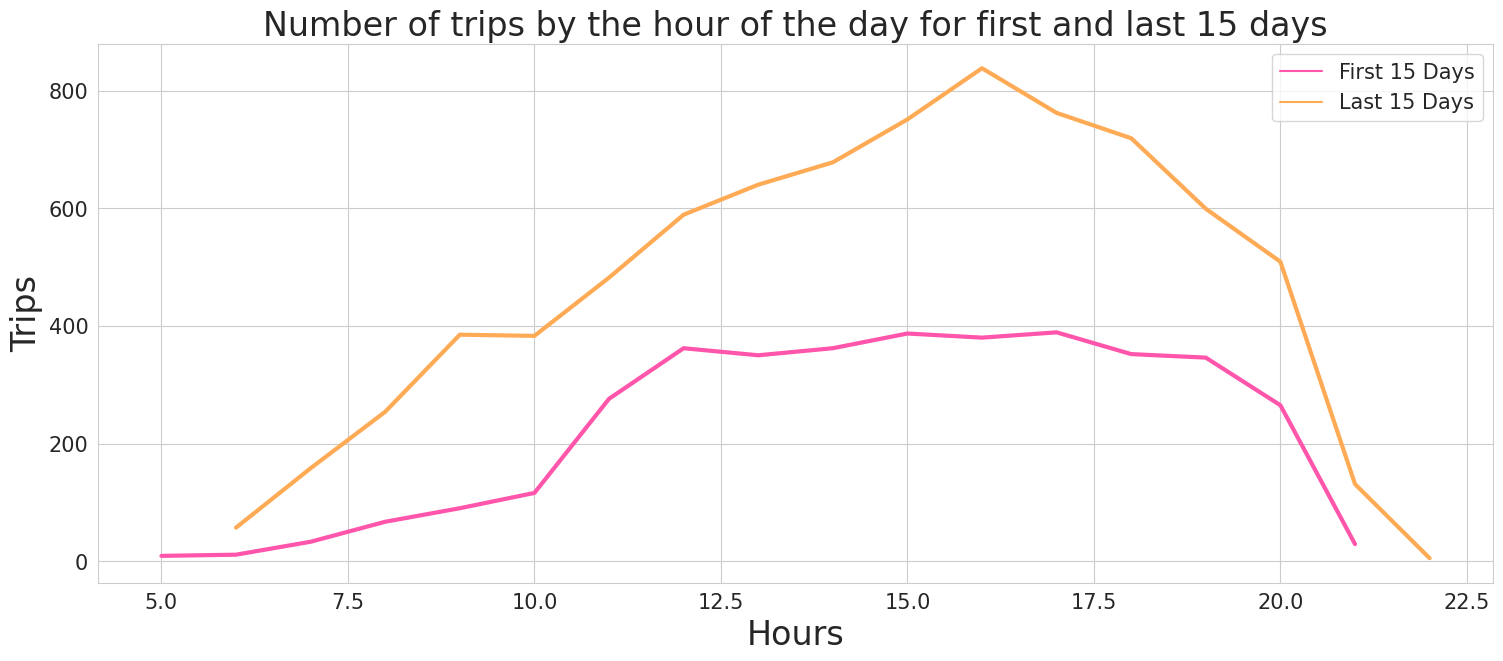

In [72]:
plt.figure(figsize=(18, 7))
sns.lineplot(x="Hour", y="Trips", hue="Time Period", data=fltdh, palette="spring", linewidth=3)
plt.title("Number of trips by the hour of the day for first and last 15 days", size=24)
plt.xlabel("Hours", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 8. Starts analysis


#### 8.1. Starts count on map

In [73]:
df_location_start = df[['Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
df_location_start, counts_start = np.unique(df_location_start, return_counts=True, axis=0)
df_location_start = np.append(df_location_start, counts_start.reshape((df_location_start.shape[0], -1)), axis=1)

In [74]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[38.259, -85.677], zoom_start=12)
    for row in data:
        lat = row[0]
        long = row[1]
        count = row[2]
        radius = count / 3500
        color = "#FF4500"
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Starts numer : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(
            location_start_map)
    return location_start_map


draw_starts_number_map(df_location_start)

#### 8.1. Put back location

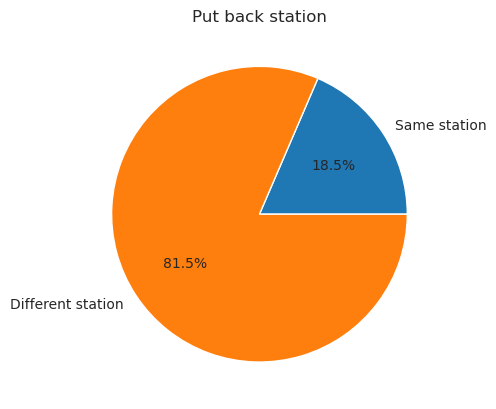

In [75]:
areas = df[["Start Area Name", 'End Area Name']].value_counts().to_frame().reset_index()
areas.columns = ["Start Area Name", 'End Area Name', "count"]
same_district = areas[(areas["Start Area Name"] == areas['End Area Name'])].reset_index()
different_district = areas[(areas["Start Area Name"] != areas['End Area Name'])].reset_index()

fig, ax = plt.subplots()
ax.pie([same_district["count"].sum(), different_district["count"].sum()],
       labels=["Same station", "Different station"], autopct='%1.1f%%')
plt.title("Put back station")
plt.show()

### 9. Traffic flow analysis


In [76]:
areas = df[["Start Area Name", 'End Area Name']].dropna()
unique_areas = np.unique(areas)
area_count = unique_areas.shape[0]

areas_map = {}
for i, area_no in enumerate(unique_areas):
    areas_map[area_no] = i

different_district = areas[
    (areas["Start Area Name"] != areas['End Area Name'])]  #.reset_index()

transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)
for i, trip in enumerate(different_district.iloc):
    t0 = np.str(trip[0])
    t1 = np.str(trip[1])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [77]:
transfer_arr_norm = transfer_arr / np.linalg.norm(transfer_arr)
print(transfer_arr_norm.shape)

(130, 130)


In [78]:
area_geo_start_position = df[['Start Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
area_geo_start_position = area_geo_start_position.drop_duplicates(subset="Start Area Name")
area_geo_start_position = area_geo_start_position.sort_values(by=['Start Area Name'])
area_geo_start_position = np.array(area_geo_start_position)
area_geo_end_position = df[['End Area Name', 'End Centroid Latitude', 'End Centroid Longitude']].dropna()
area_geo_end_position = area_geo_end_position.drop_duplicates(subset="End Area Name")
area_geo_end_position = area_geo_end_position.sort_values(by=['End Area Name'])
area_geo_end_position = np.array(area_geo_end_position)
area_geo_position = np.concatenate((area_geo_start_position,area_geo_end_position),0)

In [79]:
list_colors = [
    "#00FF00",
    "#12FF00",
    "#24FF00",
    "#35FF00",
    "#47FF00",
    "#58FF00",
    "#6AFF00",
    "#7CFF00",
    "#8DFF00",
    "#9FFF00",
    "#B0FF00",
    "#C2FF00",
    "#D4FF00",
    "#E5FF00",
    "#F7FF00",
    "#FFF600",
    "#FFE400",
    "#FFD300",
    "#FFC100",
    "#FFAF00",
    "#FF9E00",
    "#FF8C00",
    "#FF7B00",
    "#FF6900",
    "#FF5700",
    "#FF4600",
    "#FF3400",
    "#FF2300",
    "#FF1100",
    "#FF0000",
]
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

In [80]:
def draw_flow_map(treshold=1):
    max_count = np.max(transfer_arr)
    print(max_count)
    location_start_map = folium.Map(location=[38.259, -85.677], zoom_start=12)
    for y in range(transfer_arr.shape[0]):
        for x in range(transfer_arr.shape[1]):
            if x > y and np.abs(transfer_arr[x, y]) > max_count * treshold:
                start_lat = area_geo_position[x, 1]
                start_long = area_geo_position[x, 2]
                end_lat = area_geo_position[y, 1]
                end_long = area_geo_position[y, 2]

                coordinates = [
                    [start_lat, start_long],
                    [end_lat, end_long]
                ]

                color = np.floor(np.log(np.abs(transfer_arr[x, y])) * (30 / np.ceil(np.log(max_count))))
                line = folium.PolyLine(locations=coordinates, weight=color / 2, color=color_dict[color])
                location_start_map.add_child(line)

                geodesic = Geod(ellps='WGS84')
                if transfer_arr[x, y] > 0:
                    rotation = geodesic.inv(start_long, start_lat, end_long, end_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(location=(
                    (end_lat - start_lat) * 0.95 + start_lat, (end_long - start_long) * 0.95 + start_long),
                                                             color=color_dict[color], number_of_sides=3,
                                                             radius=color * 0.75, rotation=rotation)
                else:
                    rotation = geodesic.inv(end_long, end_lat, start_long, start_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(
                        location=((start_lat - end_lat) * 0.95 + end_lat, (start_long - end_long) * 0.95 + end_long),
                        color=color_dict[color], number_of_sides=3, radius=color * 0.75, rotation=rotation)
                location_start_map.add_child(arrow_head)
    return location_start_map

In [81]:
draw_flow_map(0.01)

3921


#### 9.1. Traffic flow - morning

In [82]:
def parseDateTime(dateTime: str, fromTime: int, toTime: int):
    result = []
    for dT in dateTime:
        hour = int(dT.split(':')[0])
        if fromTime <= hour <= toTime:
            result.append(True)
        else:
            result.append(False)
    return np.array(result)

In [83]:
areas = df[["StartTime", "Start Area Name", "End Area Name"]].dropna()
district_filter = np.array(areas["Start Area Name"] != areas['End Area Name'])
hour_filter = parseDateTime(areas['StartTime'], 10, 14)
sum_filter = []
for i in range(len(district_filter)):
    if district_filter[i] == True and hour_filter[i] == True:
        sum_filter.append(True)
    else:
        sum_filter.append(False)
hour_district = np.array(areas[sum_filter])
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(hour_district):
    t0 = np.str(trip[1])
    t1 = np.str(trip[2])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [84]:
draw_flow_map(0.01)

1547


#### 9.2. Traffic flow - afternoon


In [85]:
draw_flow_map(0.01)

1547


#### 9.3 Traffic flow per hour


In [86]:
start_area = df[['Start Area Name', 'Hour']].groupby(
    ["Start Area Name", "Hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]
start_area["Type"] = ["Start"] * len(start_area)
end_area = df[['End Area Name', 'Hour']].groupby(
    ["End Area Name", "Hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]
end_area["Type"] = ["End"] * len(end_area)
area_hour_start_end = pd.concat([start_area, end_area])
area_hour_start_end

,Area,Hour,Trips,Type
0,Abraham Flexner Way,0,66,Start
1,Abraham Flexner Way,1,19,Start
2,Abraham Flexner Way,2,21,Start
3,Abraham Flexner Way,3,36,Start
4,Abraham Flexner Way,4,59,Start
...,...,...,...,...
2030,Zorn Avenue,19,46,End
2031,Zorn Avenue,20,51,End
2032,Zorn Avenue,21,24,End
2033,Zorn Avenue,22,20,End


In [89]:
def plot_area_hour_start_end(district):
    plt.figure(figsize=(13, 5))
    sns.barplot(x="Hour", y="Trips", hue="Type", data=area_hour_start_end[area_hour_start_end['Area'] == district],
                palette="hsv")
    plt.title(f'Number of starts and ends by hour in {district}', size=24)
    plt.xlabel("Hours", size=24)
    plt.ylabel("Trips", size=24)
    plt.legend(prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

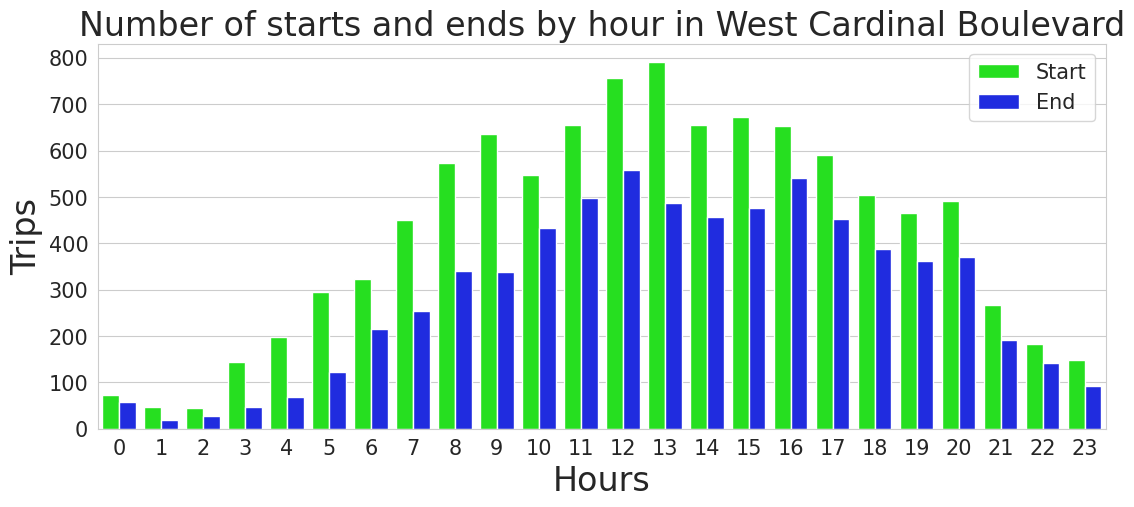

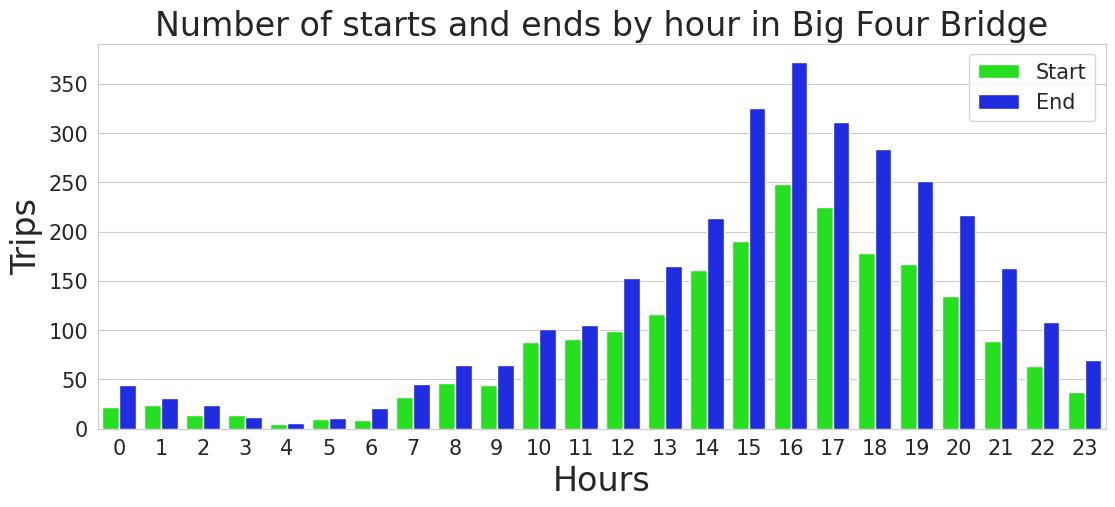

In [93]:
districts = ["West Cardinal Boulevard","Big Four Bridge"]
for district in districts:
    plot_area_hour_start_end(district)